In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(64,64)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())

    
    # Calculate the sum of each row (goro 합)
    row_sums = np.sum(attention_map, axis=1)
    print("Row sums:", row_sums)

    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=False, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

    # Plot bar chart for the row sums
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(row_sums)), row_sums, color='blue')
    plt.title("Sums of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    
    # Set x-axis ticks to be integers only
    plt.xticks(np.arange(len(row_sums)), np.arange(len(row_sums)).astype(int))
    plt.show()

In [4]:
def set_random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)

In [5]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]
        
        # Add a variable to store the alpha values
        self.alpha = None
         
         # Add attributes to store intermediate outputs
        self.V_output = None
        self.final_output = None

    def random_op(self):
        # 무작위 시드 고정
        set_random_seed(42)  # 원하는 시드 값 설정
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
    
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)

        # print("QSAL_pennylane initial value:", V_output)
        
        # Calculate alpha and store it in the instance variable
        self.alpha = torch.exp(-(Q_output - K_output)**2).transpose(0, 1)
        # Example usage:
        # visualize_attention(self.alpha)
        V_output=V_output.transpose(0,1)
        output=[]
        
        # print("Q_output size:", Q_output.size())
        # print("K_output size:", K_output.size())
        # print("V_output size:", V_output.size())


        for i in range(self.seq_num):
            
            Sum_a=torch.sum(self.alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(self.alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        
        self.V_output = V_output
        self.final_output = input + torch.stack(output).transpose(0, 1)

        # Print the return value
        # print("QSAL_pennylane return value:", final_output)

        return self.final_output


class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):
        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 10)
        self.final_layer=self.final_layer.float()

    def forward(self,input):
        print(input.shape)
        x=self.Qnn(input)
        x=torch.flatten(x,start_dim=1)
        # print('done2')
        output = torch.sigmoid(self.final_layer(x))
        # print('done3')
        return output

In [6]:
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# CIFAR-10 데이터 불러오기
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# 데이터 정규화 (0-255 값을 0-1 사이로)
X_train_full = X_train_full.astype('float32') / 255.0
X_test_full = X_test_full.astype('float32') / 255.0

# RGB -> Grayscale 변환
# 공식: 0.299*R + 0.587*G + 0.114*B
X_train_gray = np.dot(X_train_full[...,:3], [0.299, 0.587, 0.114])
X_test_gray = np.dot(X_test_full[...,:3], [0.299, 0.587, 0.114])

# 원하는 두 개의 클래스만 선택 (예: 클래스 0과 1)
selected_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# 클래스 0과 1에 해당하는 데이터만 선택 (train set)
train_mask = np.isin(y_train_full, selected_classes)
X_train_filtered = X_train_gray[train_mask.squeeze()]
y_train_filtered = y_train_full[train_mask.squeeze()]

# # 클래스 0과 1에 해당하는 데이터만 선택 (test set)
# test_mask = np.isin(y_test_full, selected_classes)
# X_test_filtered = X_test_gray[test_mask.squeeze()]
# y_test_filtered = y_test_full[test_mask.squeeze()]


# 시드 고정
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 400
indices = np.random.choice(len(X_train_filtered), num_samples, replace=False)
X_sampled, y_sampled = X_train_filtered[indices], y_train_filtered[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled, test_size=0.2, random_state=42
)

y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)


y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# 결과 출력
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Sampled train labels: {np.unique(y_train)}")
print(f"Sampled test labels: {np.unique(y_test)}")


2024-12-10 12:10:52.207715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 12:10:52.225545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 12:10:52.246027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 12:10:52.252294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 12:10:52.268187: I tensorflow/core/platform/cpu_feature_guar

Training set size: 320
Test set size: 80
Sampled train labels: [0. 1.]
Sampled test labels: [0. 1.]


In [7]:
X_train.shape

(320, 32, 32)

In [8]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 2880, 1.0: 320}


In [11]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 720, 1.0: 80}


In [12]:
# Model, optimizer, and criterion setup
model = QSANN_text_classifier(64, 4, 2, 1, 1)
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [13]:
model_save_path = "/home/jaeyeob/QVT/result/CIFAR10/qsann_classifier_multi_10.pth"

In [14]:
# Create an instance of the new model with attention extraction
model = QSANN_text_classifier(64, 4, 2, 1, 1)
model.load_state_dict(torch.load(model_save_path))
model.eval()

/tmp/ipykernel_97714/3952207360.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


QSANN_text_classifier(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=10, bias=True)
)

In [15]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: Qnn.qnn.0.init_params_Q
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_K
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: Qnn.qnn.0.init_params_V
Shape: torch.Size([64, 12])
Number of parameters: 768
--------------------------------------------------
Parameter name: final_layer.weight
Shape: torch.Size([10, 1024])
Number of parameters: 10240
--------------------------------------------------
Parameter name: final_layer.bias
Shape: torch.Size([10])
Number of parameters: 10
--------------------------------------------------
Total number of trainable parameters: 12554


In [16]:
from torchsummary import summary
summary(model, input_size=(49, 16))  # (sequence_length, embed_size)


/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([2, 49, 16])


IndexError: index 49 is out of bounds for dimension 1 with size 49

In [ ]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

In [20]:
# for iepoch in tqdm(range(30)):
#     optimizer.zero_grad()
#     X_tensor=torch.tensor(X_train)
#     predictions=model(X_tensor.float()).squeeze(1)
#     #predictions=torch.sign(predictions)
#     #print(predictions)
#     label=torch.tensor(y_train)
#     #for i in range(len(label)):
#     #    if label[i]==1:
#     #        label[i] = 0
#     #    else:
#     #        label[i]=1
#     #print(label)
#     loss = criterion(predictions, label.float())
#     acc = multi_accuracy(predictions, label)
#     print('')
#     print('Accuracy:',acc)
#     print('')
#     print(loss)
#     loss.backward()
#     optimizer.step()

torch.Size([80, 49, 16])
Row sums: [42.4103   45.73095  42.21721  42.995346 44.99029  43.111485 44.220314
 45.805046 45.480125 44.84762  45.004078 43.709167 43.757072 43.737522
 15.934391 45.262802 43.57441  44.627636 44.60622  45.37068  45.47893
 45.74514  41.971264 43.488735 44.072468 42.622665 43.203133 45.410393
 42.01279  44.843803 45.0673   42.833336 44.640682 42.155575 44.676006
 43.171494 42.241505 44.4216   43.706818 43.524593 44.065067 45.60945
 37.276653 41.06029  45.26065  43.083294 43.50709  44.654747 32.171932]


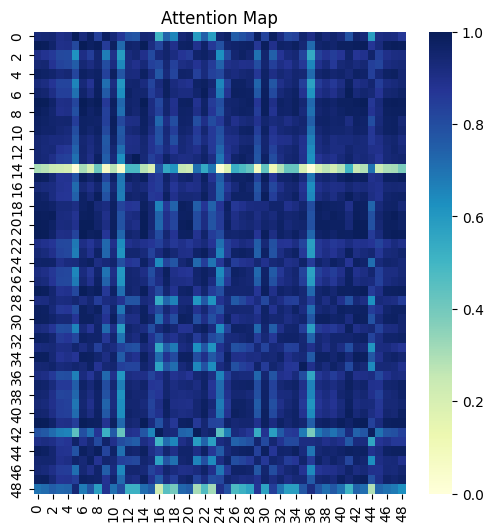

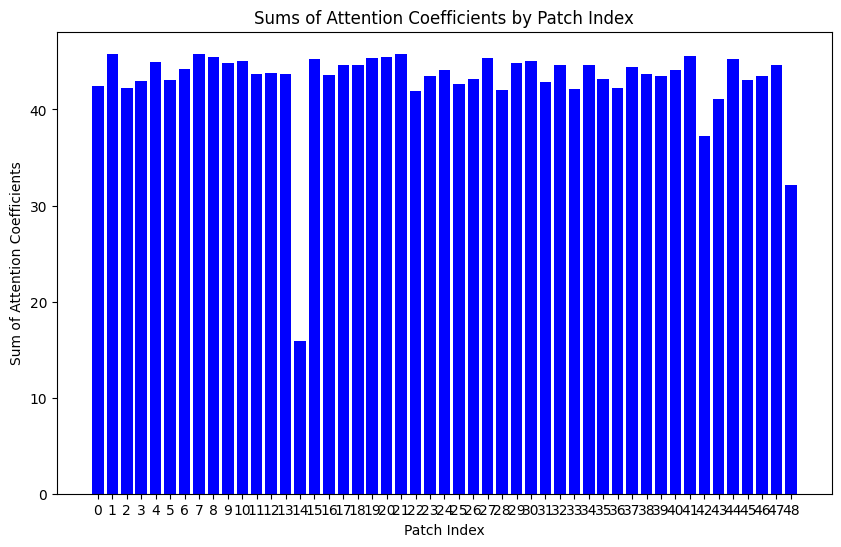

tensor([8, 4, 3, 2, 4, 3, 5, 7, 1, 5, 2, 4, 8, 1, 2, 5, 3, 7, 1, 9, 5, 7, 0, 9,
        0, 4, 9, 7, 0, 9, 7, 7, 2, 1, 1, 0, 9, 2, 4, 9, 4, 4, 2, 0, 4, 0, 3, 8,
        2, 3, 9, 7, 2, 0, 2, 4, 4, 6, 1, 8, 3, 7, 0, 9, 9, 3, 0, 7, 4, 7, 3, 0,
        3, 4, 1, 7, 3, 7, 8, 0])
tensor([8., 4., 3., 2., 4., 8., 5., 7., 1., 5., 2., 6., 8., 1., 6., 5., 3., 5.,
        1., 9., 5., 7., 0., 9., 0., 0., 9., 7., 0., 9., 7., 5., 6., 1., 1., 6.,
        7., 2., 4., 9., 4., 4., 2., 0., 4., 6., 3., 8., 2., 3., 9., 5., 2., 0.,
        4., 4., 4., 8., 1., 8., 3., 7., 2., 9., 7., 3., 1., 5., 2., 7., 3., 0.,
        3., 6., 1., 7., 3., 5., 8., 0.], dtype=torch.float64)

Accuracy: 0.75

AUROC: 0.9630843882818487

Precision (macro): 0.7230808080808081

Recall (macro): 0.7325396825396825

F1 Score (macro): 0.7075715589879675

AUPRC (macro): 0.7847203301645704



In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, average_precision_score

X_tensor=torch.tensor(X_test)
predictions=model(X_tensor.float()).squeeze(1)
label=torch.tensor(y_test)

loss = criterion(predictions, label.float())

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Ensure labels_np is in class label form, not one-hot encoded
if labels_np.ndim > 1:
    labels_np = np.argmax(labels_np, axis=1)


# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
# print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')

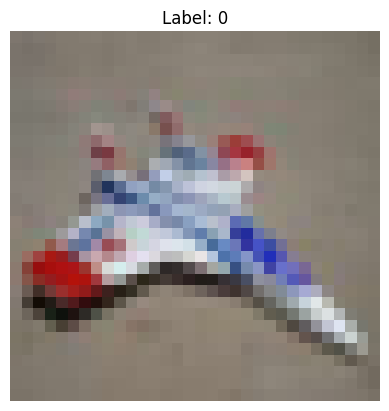

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드
cifar10 = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 첫 번째 샘플 추출
image = train_images[30]

# 이미지 시각화
plt.imshow(image)
plt.title(f'Label: {train_labels[30][0]}')
plt.axis('off')
plt.show()


In [32]:
image_gray = np.dot(image[...,:3], [0.299, 0.587, 0.114])
single = np.array([split_into_non_overlapping_patches(image_gray)])

In [33]:
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample


In [34]:
# Attention value extraction (after forward pass, assuming attention is part of the output)
class AttentionExtractor(QSANN_text_classifier):
    def __init__(self, S, n, Denc, D, num_layers):
        super().__init__(S, n, Denc, D, num_layers)
        self.attention_values = None

    def forward(self, input):
        x = self.Qnn(input)
        x = torch.flatten(x, start_dim=1)
        
        # Extract attention values from the QSAL layers (assuming alpha in the QSAL_pennylane)
        self.attention_values = self.Qnn.qsal_lst[0].alpha  # Example for first QSAL layer
        output = torch.sigmoid(self.final_layer(x))
        return output


In [35]:
# Create an instance of the new model with attention extraction
attention_model = AttentionExtractor(64, 4, 2, 1, 1)
attention_model.load_state_dict(torch.load(model_save_path))
attention_model.eval()

/tmp/ipykernel_97714/3411256959.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_model.load_state_dict(torch.load(model_save_path))


AttentionExtractor(
  (Qnn): QSANN_pennylane(
    (qnn): Sequential(
      (0): QSAL_pennylane()
    )
  )
  (final_layer): Linear(in_features=1024, out_features=10, bias=True)
)

In [36]:
single_sample

tensor([[[119.4800, 116.2950, 120.1810,  ..., 117.1810, 119.1810, 120.2520],
         [123.1380, 123.1380, 125.1380,  ..., 122.1380, 125.7250, 124.1380],
         [123.1380, 125.1380, 127.1380,  ..., 127.7250, 127.1380, 128.1380],
         ...,
         [127.6220, 129.1380, 130.1380,  ..., 126.2520, 129.1380, 129.1380],
         [127.0240, 127.2690, 130.3830,  ..., 126.6650, 124.6650, 123.6650],
         [112.3830,  90.1380, 106.0240,  ..., 120.5510, 119.1380, 114.1380]]])

In [37]:
o1 = attention_model(single_sample)

In [38]:
single_sample.shape

torch.Size([1, 64, 16])

In [39]:
# Intermediate 값 확인
for i, layer in enumerate(attention_model.Qnn.qsal_lst):
    print(f"Layer {i + 1} V_output (dependent on input_data):")
    print(layer.V_output)
    print(f"Layer {i + 1} Final_output (dependent on input_data):")
    print(layer.final_output)


Layer 1 V_output (dependent on input_data):
tensor([[[-0.5852, -0.5852, -0.5852,  ..., -0.5852, -0.5852, -0.5852],
         [ 0.3191,  0.3191,  0.3191,  ...,  0.3191,  0.3191,  0.3191],
         [ 0.0412,  0.0412,  0.0412,  ...,  0.0412,  0.0412,  0.0412],
         ...,
         [ 0.4372,  0.4372,  0.4372,  ...,  0.4372,  0.4372,  0.4372],
         [ 0.1195,  0.1195,  0.1195,  ...,  0.1195,  0.1195,  0.1195],
         [ 0.4104,  0.4104,  0.4104,  ...,  0.4104,  0.4104,  0.4104]]],
       grad_fn=<TransposeBackward0>)
Layer 1 Final_output (dependent on input_data):
tensor([[[119.5141, 116.3291, 120.2151,  ..., 117.2151, 119.2151, 120.2861],
         [123.1608, 123.1608, 125.1608,  ..., 122.1608, 125.7478, 124.1608],
         [123.1668, 125.1668, 127.1668,  ..., 127.7538, 127.1668, 128.1668],
         ...,
         [127.6503, 129.1663, 130.1663,  ..., 126.2803, 129.1663, 129.1663],
         [127.0570, 127.3020, 130.4160,  ..., 126.6980, 124.6980, 123.6980],
         [112.4118,  90.1668, 

In [40]:
y1 = layer.V_output.squeeze()

In [41]:
y2 = layer.final_output.squeeze()

In [42]:
import torch
import torch.nn.functional as F

# 길이 (Norm) 계산
lengths_y1 = torch.norm(y1, dim=1)  # 49개의 벡터 각각에 대해 계산
lengths_y2 = torch.norm(y2, dim=1)  # 49개의 벡터 각각에 대해 계산

# 길이 비율 계산
length_ratios = lengths_y2 / lengths_y1

# 코사인 유사도 계산
cosine_similarities = F.cosine_similarity(y1, y2, dim=1)  # 각 벡터별로 계산

# 코사인 유사도에 Exponential 적용
exp_cosine_similarities = torch.exp(cosine_similarities)

# Element-wise multiplication (49 elements)
elementwise_product = length_ratios * exp_cosine_similarities  # Shape: [49]

# Expand to [49, 16] by repeating values along the second dimension
expanded_result = elementwise_product.unsqueeze(1).expand(-1, y1.size(1))  # Shape: [49, 16]

# 결과 출력
print("Lengths of y1:", lengths_y1)
print("Lengths of y2:", lengths_y2)
print("Length Ratios (y2 / y1):", length_ratios)
print("Cosine Similarities (y1 ~ y2):", cosine_similarities)
print("Exponential of Cosine Similarities:", exp_cosine_similarities)
print("Combined Result (Length Ratios * Exponential Cosine Similarities):", elementwise_product)
print("Expanded Result (49x16):", expanded_result)

Lengths of y1: tensor([2.3409, 1.2765, 0.1647, 0.0247, 0.8134, 0.1587, 1.3468, 2.3596, 0.2871,
        1.2774, 0.4259, 0.2561, 1.0102, 0.6412, 1.0198, 0.2227, 0.1165, 1.4677,
        0.9191, 0.7583, 0.1382, 0.3214, 0.4320, 0.6556, 0.4453, 0.1274, 0.8971,
        0.7035, 0.9852, 0.8869, 0.8039, 1.3092, 0.1935, 0.3802, 0.4680, 0.1673,
        0.0269, 0.7709, 0.1788, 0.7755, 0.1356, 0.8148, 1.2792, 0.2089, 2.7282,
        0.0749, 1.1369, 0.0703, 1.7771, 0.9867, 1.1133, 0.3734, 1.0996, 0.9789,
        0.1883, 1.6069, 1.5472, 1.2048, 0.6119, 0.8334, 0.1411, 1.7488, 0.4781,
        1.6416], grad_fn=<LinalgVectorNormBackward0>)
Lengths of y2: tensor([469.5639, 493.0781, 500.6396, 514.8554, 524.3010, 513.7042, 500.6215,
        472.0266, 483.1399, 511.0695, 510.2483, 517.0010, 530.2117, 520.1874,
        506.2596, 487.7057, 494.5801, 510.4882, 521.5133, 522.0390, 510.2299,
        494.6953, 512.7274, 491.5229, 513.2436, 512.9547, 535.7058, 658.6931,
        744.2216, 589.0803, 530.3743, 497.95

In [43]:
expanded_result.shape

torch.Size([64, 16])

In [44]:
weights = attention_model.final_layer.weight
weights

Parameter containing:
tensor([[ 0.0502,  0.0110,  0.0079,  ..., -0.1683, -0.1462, -0.1284],
        [ 0.0160, -0.0018,  0.0173,  ...,  0.0892,  0.0907,  0.0937],
        [-0.0160, -0.0245,  0.0277,  ...,  0.0432,  0.0084,  0.0266],
        ...,
        [-0.0233,  0.0323,  0.0721,  ...,  0.0917,  0.0786,  0.0614],
        [ 0.0807,  0.1091,  0.1002,  ..., -0.1437, -0.1079, -0.1477],
        [ 0.1050,  0.1004,  0.0899,  ...,  0.0247,  0.0263, -0.0158]],
       requires_grad=True)

In [45]:
# 출력 옵션 변경: 전체 텐서 출력
torch.set_printoptions(profile="full")

# 출력 옵션을 기본값으로 되돌리기
# torch.set_printoptions(profile="default")
weights.shape

torch.Size([10, 1024])

In [46]:
weights[0]

tensor([ 5.0225e-02,  1.1034e-02,  7.9240e-03,  1.3674e-02,  3.3280e-02,
         1.4400e-02,  4.0518e-02,  4.8702e-02,  6.5020e-02,  2.4589e-02,
         5.5196e-02,  4.4174e-02,  7.4753e-02,  6.3518e-02,  7.9265e-02,
         4.9418e-02, -7.5221e-02, -6.7411e-02, -5.3580e-02, -3.6068e-02,
        -6.6310e-03,  5.6610e-03,  3.8808e-03, -4.9319e-02,  3.0592e-02,
         4.9751e-02,  4.6337e-02,  2.8382e-03,  6.1763e-02,  6.3085e-02,
         7.9524e-02,  4.9221e-02, -6.2819e-02, -4.3652e-02, -4.0912e-02,
        -1.2979e-02, -5.1036e-02, -1.7262e-03, -2.4273e-02, -3.3490e-02,
         1.8037e-02,  7.9414e-03, -3.3000e-02, -6.0448e-03,  1.6560e-02,
        -9.5493e-02, -1.3043e-01, -6.5011e-02, -2.3211e-02, -1.3401e-02,
        -2.1506e-03,  8.7358e-03, -2.3219e-02, -5.8301e-04,  4.5126e-02,
         1.9434e-02, -2.2580e-02,  1.0735e-02,  6.0746e-03,  4.8223e-02,
        -3.2610e-02, -6.8188e-03,  1.3129e-02,  2.9274e-02,  1.4569e-03,
         5.5899e-02,  2.7351e-02, -2.1514e-02,  1.8

In [47]:
positive_weights = torch.clamp(weights[0], min=0)

print(positive_weights)

tensor([5.0225e-02, 1.1034e-02, 7.9240e-03, 1.3674e-02, 3.3280e-02, 1.4400e-02,
        4.0518e-02, 4.8702e-02, 6.5020e-02, 2.4589e-02, 5.5196e-02, 4.4174e-02,
        7.4753e-02, 6.3518e-02, 7.9265e-02, 4.9418e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.6610e-03, 3.8808e-03, 0.0000e+00,
        3.0592e-02, 4.9751e-02, 4.6337e-02, 2.8382e-03, 6.1763e-02, 6.3085e-02,
        7.9524e-02, 4.9221e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8037e-02, 7.9414e-03,
        0.0000e+00, 0.0000e+00, 1.6560e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.7358e-03, 0.0000e+00, 0.0000e+00,
        4.5126e-02, 1.9434e-02, 0.0000e+00, 1.0735e-02, 6.0746e-03, 4.8223e-02,
        0.0000e+00, 0.0000e+00, 1.3129e-02, 2.9274e-02, 1.4569e-03, 5.5899e-02,
        2.7351e-02, 0.0000e+00, 1.8038e-02, 3.1423e-02, 4.7902e-02, 3.7893e-03,
        2.9331e-02, 6.0029e-02, 8.6157e-

In [48]:
reshaped_tensor = positive_weights.reshape(64, 16)
reshaped_tensor

tensor([[5.0225e-02, 1.1034e-02, 7.9240e-03, 1.3674e-02, 3.3280e-02, 1.4400e-02,
         4.0518e-02, 4.8702e-02, 6.5020e-02, 2.4589e-02, 5.5196e-02, 4.4174e-02,
         7.4753e-02, 6.3518e-02, 7.9265e-02, 4.9418e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.6610e-03,
         3.8808e-03, 0.0000e+00, 3.0592e-02, 4.9751e-02, 4.6337e-02, 2.8382e-03,
         6.1763e-02, 6.3085e-02, 7.9524e-02, 4.9221e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.8037e-02, 7.9414e-03, 0.0000e+00, 0.0000e+00,
         1.6560e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 8.7358e-03, 0.0000e+00, 0.0000e+00,
         4.5126e-02, 1.9434e-02, 0.0000e+00, 1.0735e-02, 6.0746e-03, 4.8223e-02,
         0.0000e+00, 0.0000e+00, 1.3129e-02, 2.9274e-02],
        [1.4569e-03, 5.5899e-02, 2.7351e-02, 0.0000e+00, 1.8038e-02, 3.1423e-02,
         4.7902e-02, 3.7893e-03, 2.9331

In [49]:
unit_weight = expanded_result * reshaped_tensor
unit_weight

tensor([[3.7069e+00, 8.1439e-01, 5.8483e-01, 1.0092e+00, 2.4563e+00, 1.0628e+00,
         2.9905e+00, 3.5944e+00, 4.7988e+00, 1.8148e+00, 4.0738e+00, 3.2603e+00,
         5.5172e+00, 4.6880e+00, 5.8502e+00, 3.6473e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9433e+00,
         4.0744e+00, 0.0000e+00, 3.2118e+01, 5.2233e+01, 4.8648e+01, 2.9798e+00,
         6.4844e+01, 6.6232e+01, 8.3491e+01, 5.1676e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.4904e+02, 6.5621e+01, 0.0000e+00, 0.0000e+00,
         1.3684e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9417e+02, 0.0000e+00, 0.0000e+00,
         2.5527e+03, 1.0994e+03, 0.0000e+00, 6.0726e+02, 3.4363e+02, 2.7279e+03,
         0.0000e+00, 0.0000e+00, 7.4271e+02, 1.6559e+03],
        [3.4559e-01, 1.3260e+01, 6.4880e+00, 0.0000e+00, 4.2788e+00, 7.4540e+00,
         1.1363e+01, 8.9887e-01, 6.9577

In [50]:
unit_weight.shape

torch.Size([64, 16])

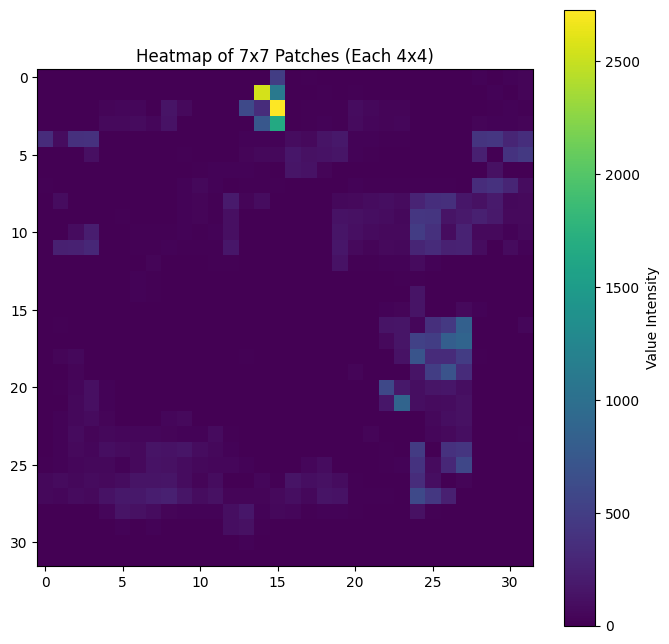

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `data` is the torch.Size([49, 16]) input converted to a numpy array for visualization
# Generate a random example array for demonstration
data = unit_weight.detach().numpy()

# Reshape each 16-dimensional patch into a 4x4 patch
patches = data.reshape(64, 4, 4)

# Combine all 49 patches into a 7x7 grid of 4x4 patches
heatmap = np.block([[patches[i * 8 + j] for j in range(8)] for i in range(8)])

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
plt.colorbar(label="Value Intensity")
plt.title("Heatmap of 7x7 Patches (Each 4x4)")
plt.show()


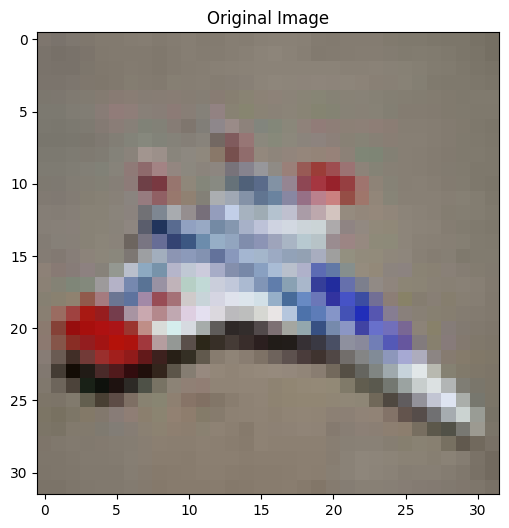

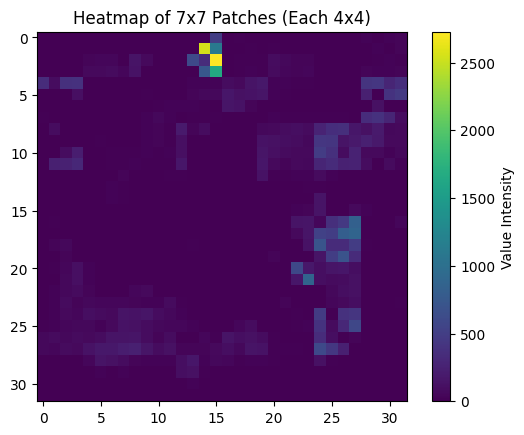

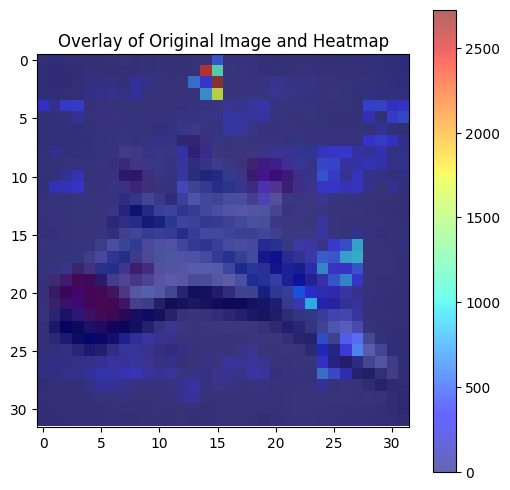

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_sample_and_heatmap(sample, patch_shape=(8, 8)):
    """
    sample: The original image (2D numpy array)
    row_sums: The sums corresponding to each patch
    patch_shape: Shape of the patch grid (e.g., (2, 2))
    """
    # 1. Plot the original sample image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Original Image")
    plt.show()

    
    plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Value Intensity")
    plt.title("Heatmap of 7x7 Patches (Each 4x4)")
    plt.show()


    # # 3. Resize the heatmap to match the sample size
    # from scipy.ndimage import zoom
    # resized_heatmap = zoom(heatmap, (sample.shape[0] / patch_shape[0], sample.shape[1] / patch_shape[1]))

    # Overlay the heatmap on the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.imshow(heatmap, cmap='jet', alpha=0.6, interpolation='none')
    plt.colorbar()
    plt.title("Overlay of Original Image and Heatmap")
    plt.show()

# Example usage
# Select a single sample from the test set
single_sample = torch.tensor(single.astype(np.float32))  # Select one sample

# Reshape the single sample back to its 2D form for visualization (assuming it's 8x8 based on CIFAR-10 patching)
original_image = image


# Visualize the sample and the heatmap
visualize_sample_and_heatmap(original_image, patch_shape=(8, 8))
